# Neural Network for Lidar Odometry

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
# file = "data/train_10k.npy" #has noise in readings
# file = "data/train_100k.npy" #no noise
# file = "data/train_straight_1k.npy" #no noise, no lateral movement relative to initial heading
file = "data/train_dxdy_100k.npy" #no noise, displacement in x and y relative to starting orientation

dataset = np.load(file)

In [3]:
#combine 100k and 200k datasets
# ds2 = np.load("data/train_dxdy_100k.npy")
# dataset = np.append(dataset, ds2, axis =0)
# np.save("data/train_dxdy_300k.npy", dataset)

In [6]:
dataset[0,100:]
np.shape(dataset)

(100000, 103)

In [ ]:
# dataset[100,:]

In [ ]:
from network import Net1, Net2

np.random.seed(1337)

#convert data from numpy to tensors
# x_train = tf.convert_to_tensor(dataset[:,:100])

#alternate dataset where we are just looking at the changes in measurement from the first sample to the 2nd
x_temp = tf.convert_to_tensor(dataset[:,:100])
x_train = np.zeros([np.shape(dataset)[0], 50])
x_train[:,:50] = x_temp[:,:50] - x_temp[:,50:100]

print(np.shape(x_train))

y_train = tf.convert_to_tensor(dataset[:,100:])

In [ ]:
model = Net1() # 50 input data (looking at differences in measurememnt between each point) 
# model = Net2() # 100 input network (looking at full data)

runLen = 30    
BS = 128 #256 #works well

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6

#     part1 = runLen//3
#     part2 = 2*runLen//3

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr

#TODO: figure out how to implement sample weight
# L = tf.keras.losses.MeanAbsoluteError()
# sample_weight = [0.3,0.3,0.4]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
#     loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
#     loss = tf.keras.losses.MeanAbsolutePercentageError(),
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=BS, epochs=runLen, verbose=1, 
                  validation_split=0.05, callbacks = [callback], shuffle=True)


In [7]:
model = tf.keras.models.load_model('dead_reckoning_1pt22_mse.kmod')

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [ ]:
r = int(np.random.rand()*100)
print(y_train[r])
out = model.predict(x_train[:100])
print(out[r])

In [ ]:
test_file = "data/test_dxdy.npy"
test_dataset = np.load(test_file)
rand = int(np.shape(test_dataset)[0]*np.random.rand())

#test for standard case
# x_test = test_dataset[:,:100]
# x_test = tf.convert_to_tensor(x_test)

#test when looking at displacement between two measurements
x_temp2 = tf.convert_to_tensor(test_dataset[:,:100])
x_test = np.zeros([np.shape(test_dataset)[0], 50])
x_test[:,:50] = x_temp2[:,:50] - x_temp2[:,50:100]

y_test = test_dataset[:,100:]
y_test = tf.convert_to_tensor(y_test)
# print(y_test[rand])
print(y_train[rand])

# guess = model.predict(x_test)
guess = model.predict(x_train)
print(guess[rand])

In [ ]:
# model.save("dead_reckoning_1pt22_mse.kmod") #got this with 50 input model

Results:

Best MSE with 100k dataset: 1.36

Best MSE with 300k dataset: 1.22

## Generate Normal Distribution Ellipse

In [720]:
# %matplotlib notebook
from utils import fit_gaussian

numpts = 10
points = np.random.randn(numpts, 2)

#adds order to points
# points[:,0] += np.linspace(1,10,numpts)
# points[:,1] += np.linspace(0,2,numpts)
 
mu, sigma = fit_gaussian(points)
print("mu = ", mu)
print("sigma = ", sigma)

eig = np.linalg.eig(sigma)
eigenval = eig[0]
eigenvec = eig[1]

print("eigenval = ", eigenval)
print("eigenvec = ", eigenvec)


mu =  [ 0.23466472 -0.08414451]
sigma =  [[0.67364823 0.19951985]
 [0.19951985 0.69978072]]
eigenval =  [0.48676724 0.88666171]
eigenvec =  [[-0.72984535 -0.68361229]
 [ 0.68361229 -0.72984535]]


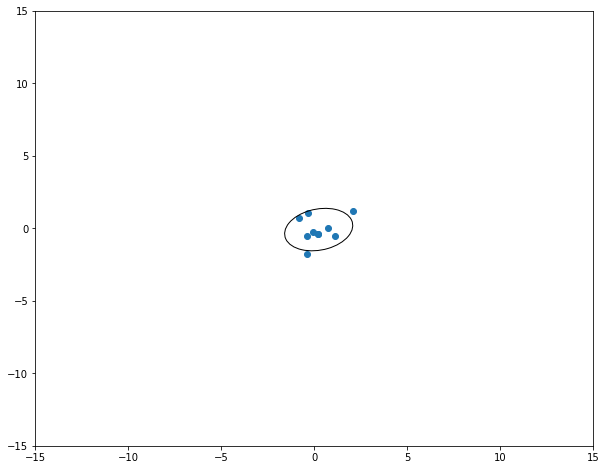

In [721]:
#draw ellipse around 1std to prove fit_guassian works
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches 

nstd = 2

fig2 = plt.figure(1)
ax2 = fig2.add_subplot()

patches = []

ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.scatter(points[:,0], points[:,1])

rot = -np.rad2deg(np.arcsin(eigenvec[0,1]/eigenvec[0,0]))
width = 2*nstd*np.sqrt(eigenval[0])
height = 2*nstd*np.sqrt(eigenval[1])

ell = Ellipse((mu[0],mu[1]),width, height, angle = rot, fill = False)
ax2.add_patch(ell)


## Best fit ellipses directly on dataset

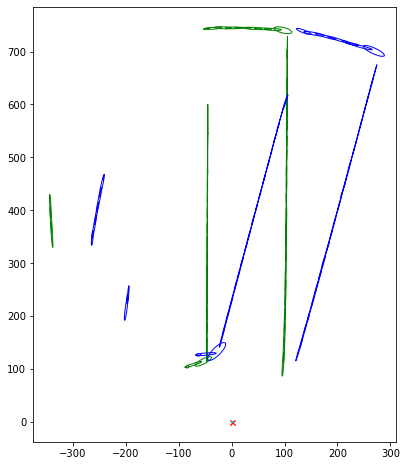

In [723]:
from utils import draw_scan, subdivide_scan

fig3 = plt.figure(1)
ax3 = fig3.add_subplot()
ax3.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
# print(rand2)

# dat = np.load("data/noisy_dxdy_100.npy") #only 50 very noisy data points
scanpts = 1000
dat = np.load("data/high_res_noisy_dxdy_100.npy")

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

rand2 = 2 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig3,ax3, pt = 2) #pt0
pp2 = draw_scan(dat2[rand2],fig3,ax3, pt = 2) #pt1

f = 25 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig3,ax3, nstd = 3, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig3,ax3, nstd = 3, fidelity = f, pt =1)

# green = before
# blue = after

Note: stretched ellipses mean cov matrix is getting close to singular

## Vanilla ICP with SVD

center_q  [14.5         0.28272719]
center_p  [ 7.4297413  15.42957793]
center_p  [14.5         0.28272719]
center_p  [14.5         0.28272719]
center_p  [14.5         0.28272719]
R:  [[ 0.99989332  0.01460676]
 [-0.01460676  0.99989332]]
t:  [-0.0025828   0.21182821]


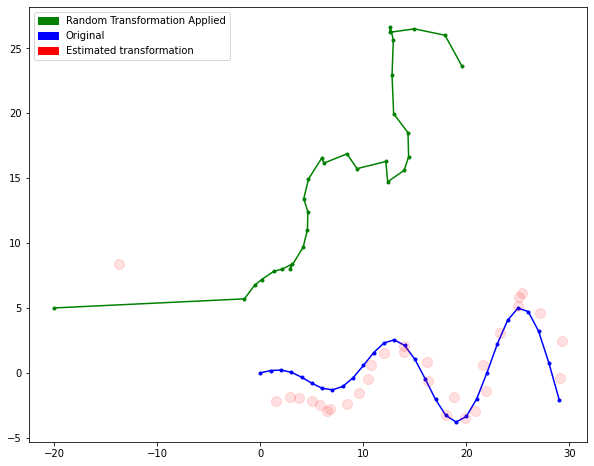

In [724]:
from ICP import vanilla_ICP
fig4 = plt.figure(1)
ax4 = fig4.add_subplot()
blue = mpatches.Patch(color='blue', label='Original')
green = mpatches.Patch(color='green', label='Random Transformation Applied')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true + 0.5*np.random.randn(num_points) #roate and add noise
# moved_data = moved_data[:,5:] #cut move dataset short
moved_data[:, 0] = np.array([-20,5]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax4.plot(P[0,:],P[1,:], 'g.-')
blue, = ax4.plot(Q[0,:], Q[1,:], 'b.-')


dc = False     #display correspondences
nc = 4    #number of cycles
R, t = vanilla_ICP(Q,P,fig4,ax4,draw=dc,num_cycles = nc)

print("R: ", R)
print("t: ", t)

## Apply vanilla ICP function with SVD to a noisy dataset. 
As predicted, results are not great.

center_q  [ 19.03241509 318.38048542]
center_p  [  0.87373439 299.56539314]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
center_p  [ 19.03241509 318.38048542]
R:  [[ 9.99999936e-01  3.57034073e-04]
 [-3.57034073e-04  9.99999936e-01]]
t:  [-0.11367147  0.00681551]


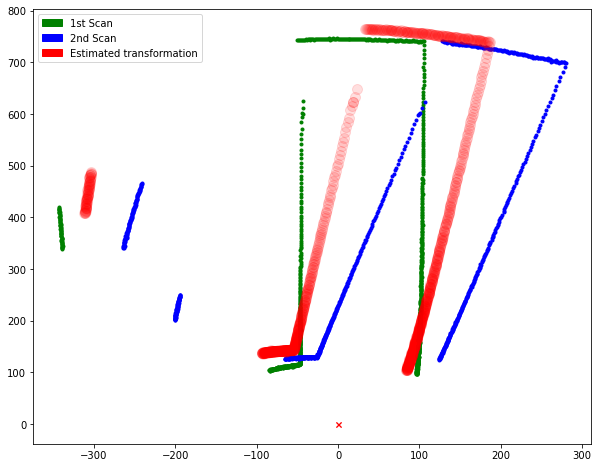

In [725]:
fig5 = plt.figure(1)
ax5 = fig5.add_subplot()

dc2 = False
nc2 = 10 #number of cycles

# rand3 = int(np.random.rand()*100)
rand3 = 2 #easy test
pp1 = draw_scan(dat1[rand3],fig5,ax5, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig5,ax5, pt = 1)

R, t = vanilla_ICP(pp2.T,pp1.T,fig5,ax5,draw=dc2,num_cycles = nc2)
print("R: ", R)
print("t: ", t)

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

## Apply Vanilla ICP to normal distribution ellipses

10  ellipses from first scan
12  ellipses from 2nd scan
center_q  [-210.4360923   418.56001508]
center_p  [-265.70133085  471.48128683]
R =  [[ 0.99873504  0.05028245]
 [-0.05028245  0.99873504]]
t =  [ 31.22190358 -65.68497877]


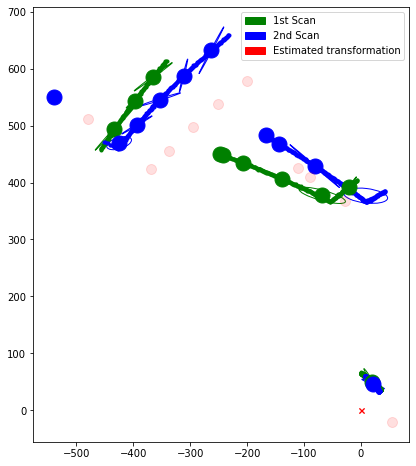

In [728]:
fig6 = plt.figure(1)
ax6 = fig6.add_subplot()
ax6.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand2 = 33 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig6,ax6, pt = 0) 
pp2 = draw_scan(dat2[rand2],fig6,ax6, pt = 1) 

f = 8 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig6,ax6, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig6,ax6, fidelity = f, pt =1)

print(len(E1), " ellipses from first scan")
print(len(E2), " ellipses from 2nd scan")

#loop through outputs to get coords of std ellipses
s1 = np.zeros([len(E1),2])
for count, i in enumerate(E1):
    s1[count] = i[0]
s2 = np.zeros([len(E2),2])
for count, i in enumerate(E2):
    s2[count] = i[0] 

if len(s1) > len(s2):
    s1 = s1[:len(s2)]
if len(s2) > len(s1):
    s2 = s2[:len(s1)]

ax6.plot(s1[:,0],s1[:,1],'g.', markersize = 30)
ax6.plot(s2[:,0],s2[:,1],'b.', markersize = 30)
    
dc3 = False
nc3 = 1 
R, t = vanilla_ICP(s1.T,s2.T,fig6,ax6,draw=dc3,num_cycles = nc3)
print("R = ", R)
print("t = ", t)

Notes:

SVD seems to translate only on the first iteration, least squares approach will update translation estimate after each iteration

error analysis more difficult on NDT

what to do about features only detected in 2nd scan?
    after n iterations of ICP, remove features with higest error, continue calculating. 
        If performance improves, these features should remain removed, else put them back in


## Least Squares ICP

[[ 0.13417418]
 [-0.06070724]
 [ 0.00156942]]


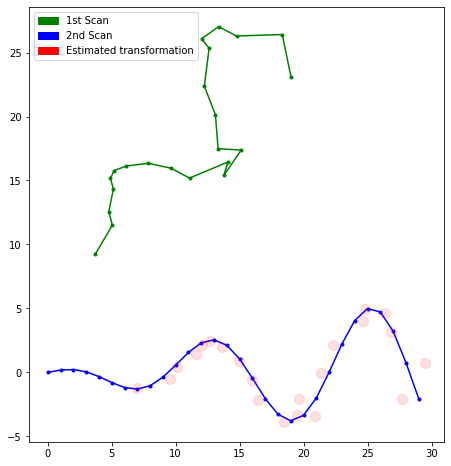

In [733]:
from  ICP import ICP_least_squares
fig7 = plt.figure(1)
ax7 = fig7.add_subplot()
ax7.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true + .5*np.random.randn(num_points) #roate and add noise
moved_data = moved_data[:,8:] #cut move dataset short
# moved_data[:, 0] = np.array([-20,5]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax7.plot(P[0,:],P[1,:], 'g.-')
blue, = ax7.plot(Q[0,:], Q[1,:], 'b.-')


NC = 10
P_corrected = ICP_least_squares(Q,P,fig7,ax7, num_cycles = NC, draw = False)

Notes about Least Squares:

Less susceptable to initial conditions

capable of working with inconsistant datasets (ex: |P| = 15, |Q| = 20)

more dependant on outliars?

### Applying Least Squares to lidar scan dataset

[[-1.59560968e-01]
 [ 3.05833020e-06]
 [-2.39715774e-03]]


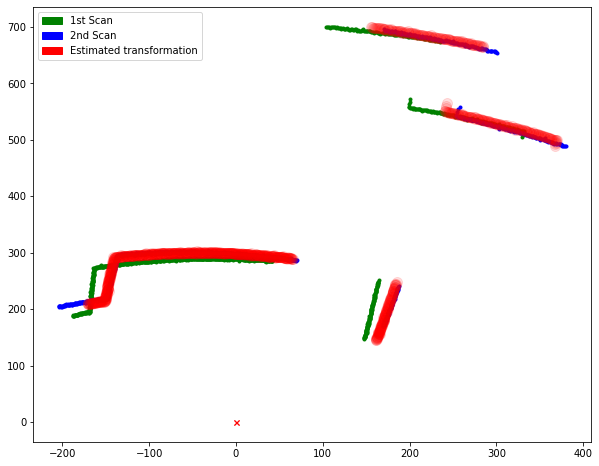

In [734]:
fig8 = plt.figure()
ax8 = fig8.add_subplot()
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand3 = int(np.random.rand()*100)
# print("scan #: ", rand3)
rand3 = 33 #or 2 for easy test
pp1 = draw_scan(dat1[rand3],fig8,ax8, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig8,ax8, pt = 1)


dc = False
nc = 10 #number of cycles
P_corrected, t, rot = ICP_least_squares(pp2.T,pp1.T,fig8,ax8, num_cycles = nc, draw = dc)
# print("t = ", t)
# print("rot = ", rot)

# Normal Distribution Transform (NDT)

93
 ------------------ cycle:  0 ----------------------
score:  542758.8874923334
grad  [[3207.56883801 1840.80875766 4844.65845186]]
x [[0. 0. 0.]]
 ------------------ cycle:  1 ----------------------
score:  547096.2437625686
grad  [[ 149.6147159  3943.06302977 1058.9090877 ]]
x [[-0.03207569 -0.01840809 -0.00484466]]
 ------------------ cycle:  2 ----------------------
score:  546461.3404411417
grad  [[-1559.46532885  1120.63170497 -1261.85275434]]
x [[-0.03357184 -0.05783872 -0.00590357]]
 ------------------ cycle:  3 ----------------------
score:  547420.637479124
grad  [[-402.25322866 1380.01898625 -184.66912227]]
x [[-0.01797718 -0.06904503 -0.00464171]]
 ------------------ cycle:  4 ----------------------
score:  547012.8570139378
grad  [[372.63410679 645.20957326 937.92924653]]
x [[-0.01395465 -0.08284522 -0.00445705]]
 ------------------ cycle:  5 ----------------------
score:  547188.6036937686
grad  [[-1696.74146615   193.1866749  -2087.17230518]]
x [[-0.01768099 -0.0892973

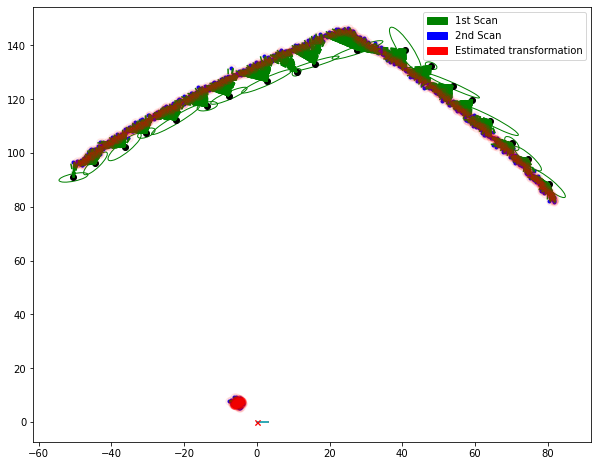

In [778]:
from NDT import NDT

fig9 = plt.figure()
ax9 = fig9.add_subplot()
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

a = int(100*np.random.rand())
print(a)
a = 21 #40 #59 #10 #97 #33 #easy test scans
fidelity = 12 # [N x N] grid of ellipses
nc = 10       # number of cycles
r, t, results = NDT(dat1[a],dat2[a],fig9,ax9, fid = fidelity, num_cycles = nc)
print("r ", r)
print("t ", t)

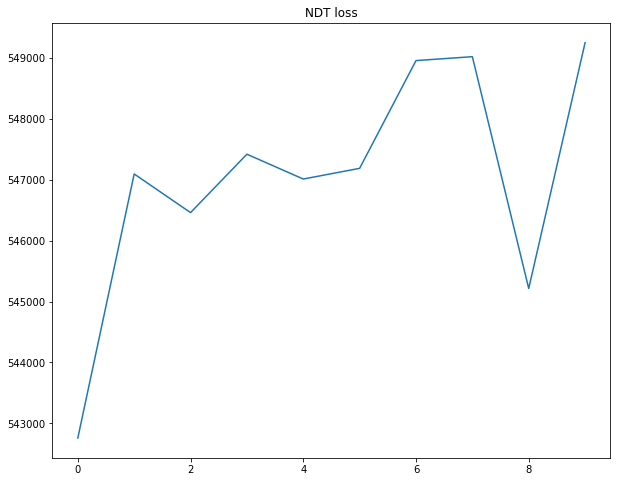

In [779]:
fig10 = plt.figure()
ax10 = fig10.add_subplot()
ax10.set_title("NDT loss")

ax10.plot(results)

In [775]:
from scipy import misc

#not going to work with our inputs

def f(x):
    #works
    return(np.sin(x+1)/4)
    
def NewtonsMethod(f, x, tolerance=0.001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

x = 3

x0 = NewtonsMethod(f, x)
print(x0)

2.1418041869523385


In [43]:
#ellipse z score equation

pt_x = 1
pt_y = 1.5

major = 1.94 #20
minor = 1.166 #12

ratio = major / minor

print("inside if < 1: ", (pt_x**2)/(minor**2) + (pt_y**2)/(major**2))

b = np.sqrt( (pt_x**2)/(ratio**2) + pt_y**2 )
print(b)
a = ratio*b
print(a)

print("z-score: ", a/major)

inside if < 1:  1.3333661110554416
1.6159326026212426
2.6886014143097863
z-score:  1.385877017685457
